In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
import datetime

from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [2]:
data = pd.read_csv('google_stock_price.csv', thousands=',')
data

,Date,Open,High,Low,Close,Volume
0,1/3/2012,325.25,332.83,324.97,663.59,7380500
1,1/4/2012,331.27,333.87,329.08,666.45,5749400
2,1/5/2012,329.83,330.75,326.89,657.21,6590300
3,1/6/2012,328.34,328.77,323.68,648.24,5405900
4,1/9/2012,322.04,322.29,309.46,620.76,11688800
...,...,...,...,...,...,...
1253,12/23/2016,790.90,792.74,787.28,789.91,623400
1254,12/27/2016,790.68,797.86,787.66,791.55,789100
1255,12/28/2016,793.70,794.23,783.20,785.05,1153800
1256,12/29/2016,783.33,785.93,778.92,782.79,744300


Text(0, 0.5, 'Stock Volume')

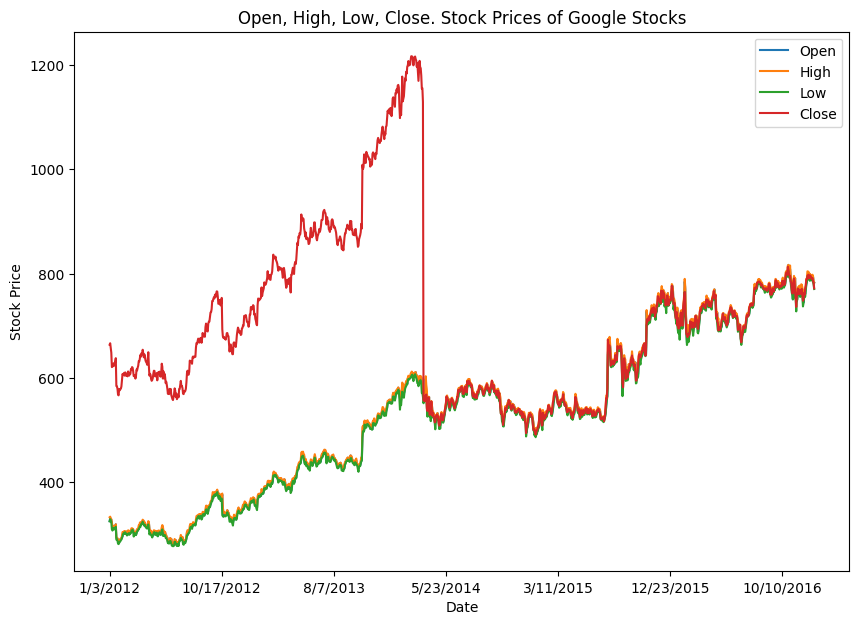

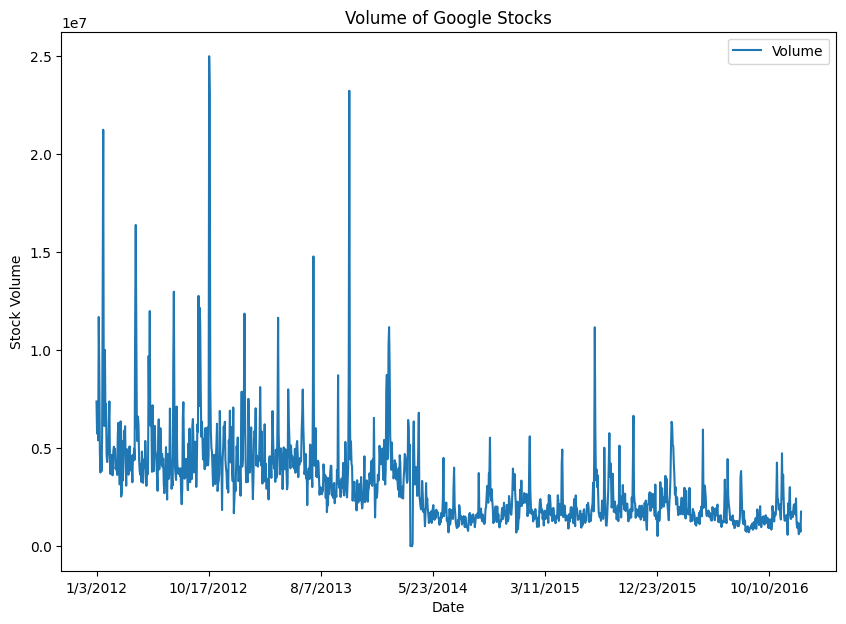

In [3]:
ax1 = data.plot(
    x="Date",
    y=["Open", "High", "Low", "Close"],
    figsize=(10,7), 
    title="Open, High, Low, Close. Stock Prices of Google Stocks"
)
ax1.set_ylabel("Stock Price")

ax2 = data.plot(
    x="Date",
    y=["Volume"],
    figsize=(10, 7),
    title="Volume of Google Stocks"
)
ax2.set_ylabel("Stock Volume")

In [4]:
data.isnull().sum()

Date      0
Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64

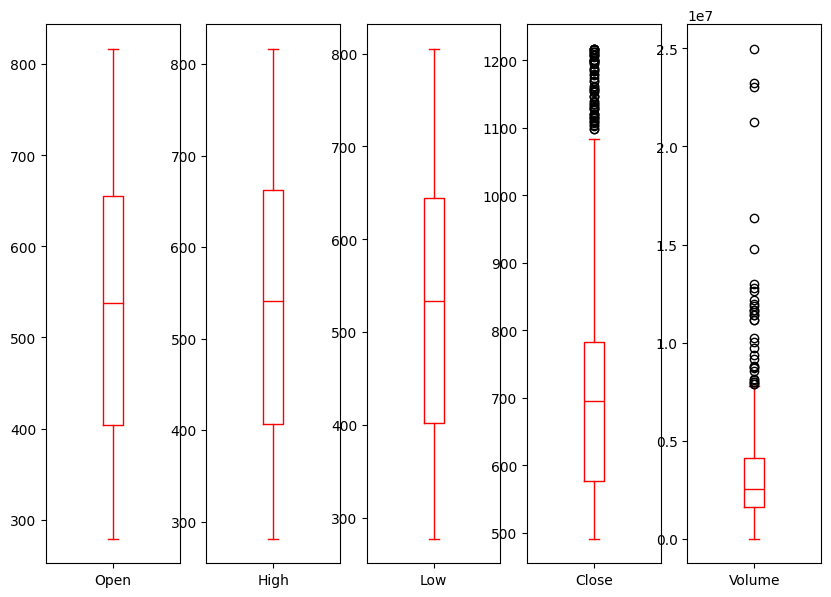

In [5]:
data[["Open", "High", "Low", "Close", "Volume"]].plot(
    kind='box',
    layout=(1,5),
    subplots=True,
    sharex=False,
    sharey=False,
    figsize=(10,7),
    color='red'
)
plt.show()

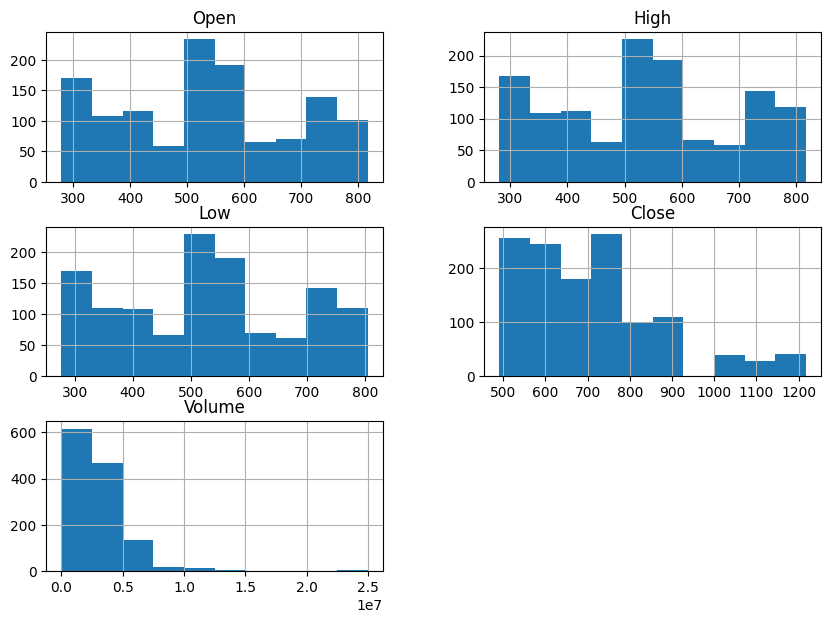

In [6]:
data.hist(figsize=(10,7))
plt.show()

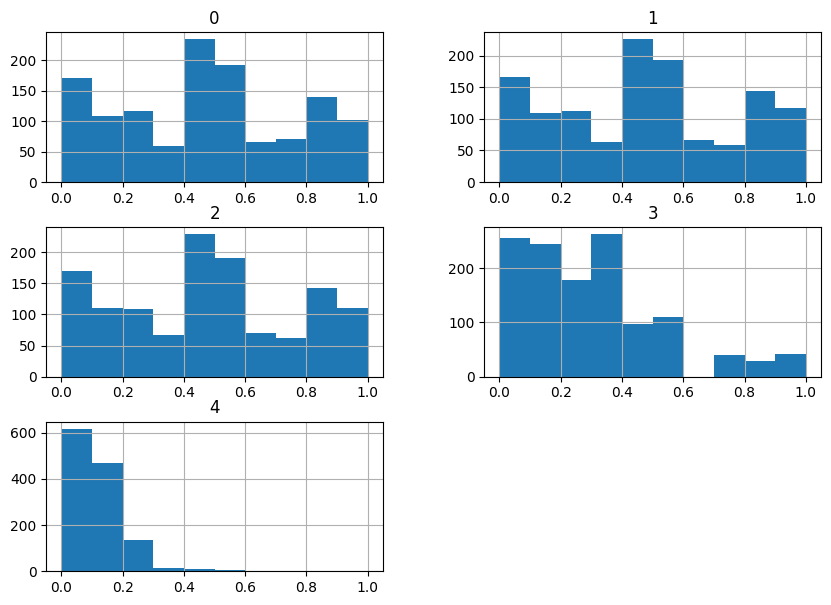

In [7]:
scaler = MinMaxScaler()
data_without_date = data.drop("Date", axis=1)
scaled_data = pd.DataFrame(scaler.fit_transform(data_without_date))

scaled_data.hist(figsize=(10, 7))
plt.show()

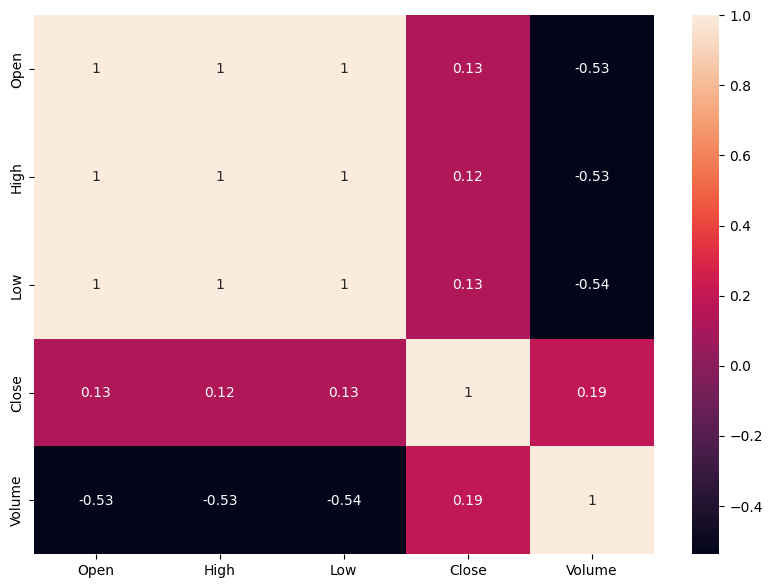

In [8]:
plt.figure(figsize=(10, 7))
sns.heatmap(data.drop("Date", axis=1).corr(), annot=True)
plt.show()

In [9]:
print(data.drop("Date", axis=1).corr())

            Open      High       Low     Close    Volume
Open    1.000000  0.999692  0.999498  0.125832 -0.530506
High    0.999692  1.000000  0.999480  0.124351 -0.526936
Low     0.999498  0.999480  1.000000  0.129001 -0.538273
Close   0.125832  0.124351  0.129001  1.000000  0.192357
Volume -0.530506 -0.526936 -0.538273  0.192357  1.000000


In [10]:
scaled_data = scaled_data.drop([0, 2, 3], axis=1)
scaled_data

,1,4
0,0.096401,0.295258
1,0.098344,0.229936
2,0.092517,0.263612
3,0.088819,0.216179
4,0.076718,0.467797
...,...,...
1253,0.955292,0.024650
1254,0.964853,0.031286
1255,0.958074,0.045891
1256,0.942574,0.029491


In [11]:
def split_seq_multivariate(sequence, n_past, n_future):
    x, y = [], []
    for window_start in range(len(sequence)):
        past_end = window_start + n_past
        future_end = past_end + n_future
        if future_end > len(sequence):
            break
        past = sequence[window_start:past_end, :]
        future = sequence[past_end:future_end, -1]
        x.append(past)
        y.append(future)
    return np.array(x), np.array(y)

In [12]:
n_steps = 60
scaled_data = scaled_data.to_numpy()
scaled_data.shape

(1258, 2)

In [13]:
x, y = split_seq_multivariate(scaled_data, n_steps, 1)
x.shape, y.shape

((1198, 60, 2), (1198, 1))

In [14]:
y = y[:, 0]
y.shape

(1198,)

In [15]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((958, 60, 2), (240, 60, 2), (958,), (240,))

In [16]:
model = Sequential()
model.add(LSTM(612, input_shape=(n_steps, 2)))
model.add(Dense(50, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(30, activation='relu'))
model.add(Dense(1))

C:\Users\Vedanshoo Kadam\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [17]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 612)                 │       1,505,520 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 50)                  │          30,650 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 50)                  │           2,550 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 30)                  │           1,530 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              31 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,540,281 (5.88 MB)

 Trainable params: 1,540,281 (5.88 MB)

 Non-trainable params: 0 (0.00 B)

In [18]:
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

In [19]:
history = model.fit(x_train, y_train, epochs=25, batch_size=32, verbose=2, validation_data=(x_test, y_test))

Epoch 1/25
30/30 - 12s - 385ms/step - loss: 0.0073 - mae: 0.0555 - val_loss: 0.0056 - val_mae: 0.0422
Epoch 2/25
30/30 - 9s - 307ms/step - loss: 0.0047 - mae: 0.0396 - val_loss: 0.0055 - val_mae: 0.0418
Epoch 3/25
30/30 - 9s - 313ms/step - loss: 0.0045 - mae: 0.0385 - val_loss: 0.0049 - val_mae: 0.0423
Epoch 4/25
30/30 - 9s - 315ms/step - loss: 0.0042 - mae: 0.0370 - val_loss: 0.0051 - val_mae: 0.0379
Epoch 5/25
30/30 - 9s - 309ms/step - loss: 0.0041 - mae: 0.0361 - val_loss: 0.0045 - val_mae: 0.0403
Epoch 6/25
30/30 - 9s - 309ms/step - loss: 0.0041 - mae: 0.0368 - val_loss: 0.0046 - val_mae: 0.0374
Epoch 7/25
30/30 - 9s - 308ms/step - loss: 0.0039 - mae: 0.0345 - val_loss: 0.0048 - val_mae: 0.0356
Epoch 8/25
30/30 - 9s - 310ms/step - loss: 0.0038 - mae: 0.0339 - val_loss: 0.0044 - val_mae: 0.0354
Epoch 9/25
30/30 - 9s - 309ms/step - loss: 0.0039 - mae: 0.0346 - val_loss: 0.0048 - val_mae: 0.0392
Epoch 10/25
30/30 - 9s - 309ms/step - loss: 0.0037 - mae: 0.0336 - val_loss: 0.0040 - val_

<Axes: >

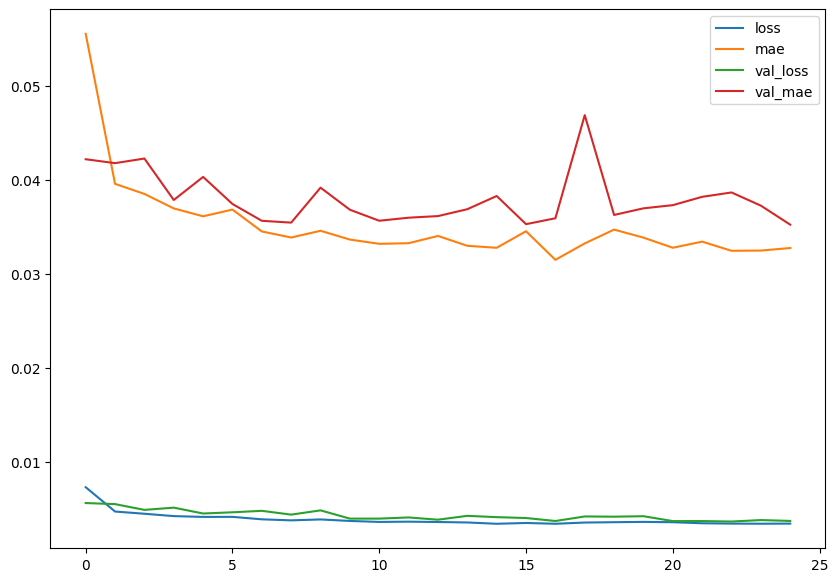

In [20]:
pd.DataFrame(history.history).plot(figsize=(10, 7))

In [21]:
model.evaluate(x_test, y_test)

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 0.0033 - mae: 0.0343


[0.003714748891070485, 0.03522615507245064]

In [22]:
predictions = model.predict(x_test)
predictions.shape

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step


(240, 1)

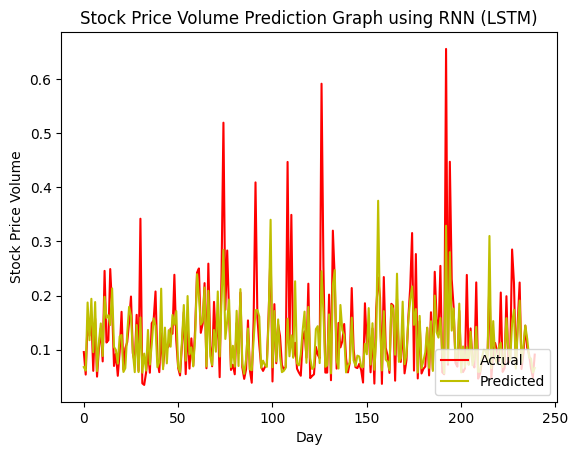

<Figure size 1000x700 with 0 Axes>

In [24]:
plt.plot(y_test, c='r')
plt.plot(predictions, c='y')
plt.xlabel('Day')
plt.ylabel('Stock Price Volume')
plt.title("Stock Price Volume Prediction Graph using RNN (LSTM)")
plt.legend(['Actual', 'Predicted'], loc = 'lower right')
plt.figure(figsize=(10, 7))
plt.show()